In [2]:
from typing import List, Tuple, TypedDict
from langgraph.graph import StateGraph

In [3]:
class Agentstate(TypedDict):
    name:str
    age: str
    final: str

In [11]:
def first_node(state:Agentstate) -> Agentstate:
    """This is the fist mnode of the sequence"""
    state['final'] = f" Hi {state['name']}"
    # print(state)
    return state

In [12]:
def second_node(state:Agentstate) -> Agentstate:
    """This is the second node of the sequence"""
    state['final'] = state['final'] + f" You are {state['age']} years old"
    return state

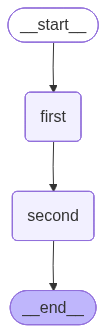

In [13]:
graph = StateGraph(Agentstate)
graph.add_node("first", first_node)
graph.add_node("second", second_node)

graph.set_entry_point("first")
graph.add_edge("first", "second")
graph.set_finish_point("second")
app = graph.compile()
app

In [14]:
ans = app.invoke({"name": "John", "age": 20})  # type: ignore

In [45]:
ans

{'name': 'John', 'age': 20, 'final': ' Hi John You are 20 years old'}

In [15]:
ans['final']

' Hi John You are 20 years old'

## Understanding State Flow in LangGraph

Let's trace how state flows through the graph:

1. **Initial Invoke**: `{"name": "John", "age": 20}` - We only provide what's needed
2. **State Schema**: `AgentState` defines all possible fields (name, age, final)
3. **Node Execution**: Each node gets the current state, can read any field, and updates what it needs
4. **State Merging**: Updates from nodes are merged back into the state
5. **Final Output**: The complete state with all fields is returned

In [ ]:
# Let's trace the state step by step
print("=== TRACING STATE FLOW ===\n")

class TracedAgentState(TypedDict):
    name: str
    age: str
    final: str
    step_log: List[str]  # Track what happens at each step

def traced_first_node(state: TracedAgentState) -> TracedAgentState:
    """First node - adds greeting"""
    print(f"📍 FIRST NODE - Input state: {dict(state)}")
    state['final'] = f"Hi {state['name']}"
    state['step_log'] = state.get('step_log', []) + ["first_node: Added greeting"]
    print(f"📍 FIRST NODE - Output state: {dict(state)}\n")
    return state

def traced_second_node(state: TracedAgentState) -> TracedAgentState:
    """Second node - adds age info"""
    print(f"📍 SECOND NODE - Input state: {dict(state)}")
    state['final'] = state['final'] + f" You are {state['age']} years old"
    state['step_log'] = state.get('step_log', []) + ["second_node: Added age info"]
    print(f"📍 SECOND NODE - Output state: {dict(state)}\n")
    return state

# Build the graph
traced_graph = StateGraph(TracedAgentState)
traced_graph.add_node("first", traced_first_node)
traced_graph.add_node("second", traced_second_node)
traced_graph.set_entry_point("first")
traced_graph.add_edge("first", "second")
traced_graph.set_finish_point("second")
traced_app = traced_graph.compile()

# Invoke with minimal input
print("🚀 INVOKING with: {'name': 'Alice', 'age': '25'}\n")
result = traced_app.invoke({"name": "Alice", "age": "25"})

print("=" * 50)
print("🎯 FINAL RESULT:")
print(f"Final message: {result['final']}")
print(f"\nStep log: {result['step_log']}")

## Key Takeaways

### ✅ State as Shared Memory
- State is like a **shared dictionary** that all nodes can access
- It persists throughout the entire graph execution
- Each node can read ANY field and write to ANY field

### ✅ Input Requirements
- You **only need to provide fields that are actually used** by nodes
- Fields can be created dynamically by nodes (like `final` in our example)
- The `TypedDict` defines what CAN exist, not what MUST be provided

### ✅ State Flow
```
User Input → Entry Node → Node 2 → ... → Exit Node → Final State
            (state)      (state)         (state)
```

### ✅ How Nodes Work
```python
def my_node(state: AgentState) -> AgentState:
    # 1. Read from state
    name = state['name']
    
    # 2. Do some work
    greeting = f"Hello {name}"
    
    # 3. Update state (merge, not replace)
    state['greeting'] = greeting
    
    # 4. Return updated state
    return state
```

### ⚠️ Important Notes
1. **State updates are merged**: You don't lose existing fields when updating
2. **Nodes are functions**: They take state in, return state out
3. **Sequential flow**: In this example, nodes run one after another
4. **Type safety**: TypedDict helps catch errors at development time